# Cellar Tracker Text Classification


In [47]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Conv1D, Dense, MaxPooling1D, GlobalMaxPooling1D, Embedding, Dropout
from keras.models import Model

%matplotlib inline

## Data Prep

We'll read the Cellar Tracker data directly from Data.World.  This will take a bit to download.  Once it's downloaded, we can do some basic analysis on the dataset to see what we're dealing with.

In [2]:
df = pd.read_csv('https://query.data.world/s/r8VVStpwMgTZlScD_VyeGd6JUEX4fm')

In [ ]:
# Don't use rows where review/points or review/text is not provided
scored_df = df[df['review/points'].notnull()]
scored_df = scored_df[scored_df['review/text'].notnull()]

print('Reviews with review/points assigned = {}'.format(len(scored_df)))

plt.hist(scored_df['review/points'].values, bins = 20)
plt.title("Review Scores Histogram")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.show()


## Learning

We're going to build a text learner that will take the review text and use it to predict a continuously-valued review score.  This dataset has other attributes that may be of use for such a task and we're not going to use those just to focus in on text classification.  Further, it may make sense to treat this problem as classification and bucket the review scores into categories (i.e. 98-100 = "AAA", 95-97 = "AA").  We may come back to considering that but initially we'll just look at it as regression.  

In [36]:
X = scored_df['review/text'].values
y = list(map(lambda v: float(v), scored_df['review/points'].values))

,chunk_id,review/points,review/text,review/time,review/userId,review/userName,wine/name,wine/variant,wine/wineId,wine/year
341097,1098,90.0,NaN,1314403200,136709,mrieussec,2007 Wyndham Estate Cabernet Sauvignon Bin 444,Cabernet Sauvignon,794158,2007.0
556564,6565,87.0,NaN,1163635200,12385,fmarcoux,2003 Alcione Puglia IGT,Aglianico,165541,2003.0
556570,6571,89.0,NaN,1160352000,12385,fmarcoux,2000 Beckmen Vineyards Syrah Estate Santa Ynez...,Syrah,230842,2000.0
556571,6572,89.0,NaN,1162944000,12385,fmarcoux,2004 Domaine de Colette R&#233;gni&#233;,Gamay,208975,2004.0


In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index

In [39]:
print ('There are {} words across all reviews'.format(len(word_index)))

There are 152285 words across all reviews


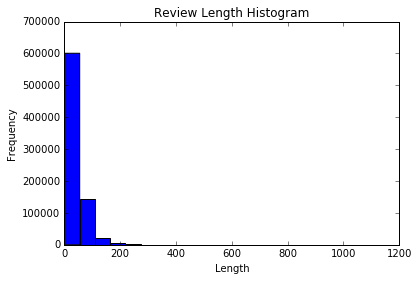

In [43]:
plt.hist(list(map(lambda seq: len(seq), sequences)), bins=20)
plt.title("Review Length Histogram")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

[1093, 922, 914, 892, 858]

In [45]:
MAX_SEQUENCE_LENGTH = 300
EMBEDDING_DIM = 50

In [ ]:
data = pad_sequences(sequences, maxlen= MAX_SEQUENCE_LENGTH)

In [52]:
target = np.asarray(y)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', target.shape)

Shape of data tensor: (773497, 300)
Shape of label tensor: (773497,)


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            embeddings_initializer = 'glorot_uniform', # not using pre-trained embeddings
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(32, 3, activation='relu')(embedded_sequences)
x = MaxPooling1D(3)(x)
#x = Dropout(.5)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
#x = Dropout(.5)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)  # global max pooling
#x = Dropout(.5)(x)

x = Dense(128, activation='relu')(x)
preds = Dense(1)(x) # no activation so that it outputs the target value directly

model = Model(sequence_input, preds)

model.compile(loss='mse', optimizer='sgd')

model.summary()

# happy learning!
history = model.fit(data, target, validation_split = .2, epochs=20, batch_size=128)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 300)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 300, 50)           7614300   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 298, 32)           4832      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 99, 32)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 97, 32)            3104      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 32, 32)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 30, 32)            3104      
__________